# COPD Risk score

Chronic obstructive pulmonary disease, or COPD, refers to a group of diseases that cause airflow blockage and breathing-related problems. It includes emphysema and chronic bronchitis. COPD makes breathing difficult for the 16 million Americans who have this disease. Millions more people suffer from COPD, but have not been diagnosed and are not being treated. Although there is no cure for COPD, it can be treated.

This notebook will use NHANES survey data to predict the COPD risk score with Logistic Regression Classifier and XGBtree, using SHAP valve to show feature importance, finally visualized with SHAP TreeExplainer both individually and in summary.

In [1]:
import warnings
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from functools import reduce
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
print(pd.__version__)

0.25.0


## Data Processing

In [11]:
data = pd.read_csv('COPD(normalized_nopyshic2_notoxicant).csv')

In [12]:
data=data.iloc[:,2:]
data = data.drop(['RaceOther Race - Including Multi-Racial'], axis=1)
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 42 columns):
Gender                                                    5400 non-null int64
NonHispanic_White                                         5400 non-null int64
NonHispanic_Black                                         5400 non-null int64
Mexican_American                                          5400 non-null int64
Other_Hispanic                                            5400 non-null int64
NonHispanic_Asian                                         5400 non-null int64
Edu                                                       5400 non-null int64
Widowed_Divorced_Separated                                5400 non-null int64
Married                                                   5400 non-null int64
Diabetes                                                  5400 non-null int64
Worried_anxious_daily                                     5400 non-null int64
Worried_anxious_weekly             

Factors are screened according to the risk factors CDC provided (https://www.cdc.gov/copd/index.html), after data cleaning, manipulating with R, the final predictors including:

Demographic Data (Age, Gender, Race, Education, Marial Status)

Medical Condition Data (Having Diabetes, Asthma, Arthritis, Coronary_heart_disease, Congestive_heart_failure, Heart_attack, Stroke)

Family History Data (Close_Relative_Heart_Attack, Asthma, Diabetes)

Health Status Data (Worried or Anxious, Depress, Serious_difficulty_walking, More_emergency_room_visits_or_overnight_hospital_stays, Overweight,  Lack_Exercise, High_Salt, Hight_Fat_Calories)

Smoke Data (Exposure_to_secondhand_smoke, Smoked_at_least_100_cigarettes_in_life, Ever_smoked_a_cigar_even_one_time, Ever_used_an_ecigarette, Ever_used_smokeless_tobacco)


The following questions are used to define the target variable.

MCQ160o - Ever told you had COPD

MCQ160k - Ever told you had chronic bronchitis

MCQ160g - Ever told you had emphysema

In [13]:
Y=data['y']
X=data.ix[:,:-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
trainDf = pd.concat([Y_train, X_train], axis=1)
testDf = pd.concat([Y_test, X_test], axis=1)
clasTest = testDf.groupby('y')['y'].count()
print(clasTest)

y
0    1505
1     115
Name: y, dtype: int64


## Modeling Process

### Model 1: Logistic Regression Classifier

In [105]:
X=np.asarray(X)
Y=np.asarray(Y)
X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)

In [90]:


class LogisticRegressionClassifier:

    def __init__(self, n=100):
        self.n = n

    def fit(self, X, Y, random_state=42, criterion='entropy'):
        X_train_p = X[Y==1]
        X_train_n = X[Y==0]
        Y_train_p = Y[Y==1]
        Y_train_n = Y[Y==0]
        l = sum(Y_train_p)
        clf_list = []
        np.random.seed(seed=random_state)
        for i in range(self.n):
            idx_n = np.random.choice(range(X_train_n.shape[0]), l)
            idx_p = np.random.choice(range(X_train_p.shape[0]), l)
            X_train_f = np.concatenate([X_train_n[idx_n, :], X_train_p[idx_p]])
            Y_train_f = np.concatenate([Y_train_n[idx_n], Y_train_p[idx_p]])
            clf = LogisticRegression()
            clf.fit(X_train_f, Y_train_f)
            clf_list.append(clf)
            print(f'\rClassifier {i+1} completed.', end='')
        self.clfs = clf_list        
    
    def coefficients(self):
        feature_importance = abs(self.clfs[0].coef_)
        for tree in self.clfs[1:]:
            feature_importance += tree.coef_
        return feature_importance/ self.n
    
    def predict(self, X):
        result_list = list(map(lambda clf: clf.predict_proba(X)[:,1], self.clfs))
        score = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return score
        
    def report(self, X, Y):
        y_hat = self.predict(X)
        print(classification_report(Y_test, 1.*(y_hat>0.5)))
    def predict_proba(self,X):
        result_list = list(map(lambda clf: 100*clf.predict_proba(X)[:,1], self.clfs))
        proba = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return proba

In [91]:
### Model Training

In [92]:
btc = LogisticRegressionClassifier(500)
btc.fit(X_train, Y_train)
y_hat = 1.0 * (btc.predict(X_test)>0.5)

Classifier 500 completed.

In [93]:
btc.coefficients() # avg coefficients of n classifiers 

array([[-0.29249838, -0.62579912,  0.07541766,  0.1749971 ,  0.2157862 ,
        -0.46057109,  0.18595277,  0.30874536,  0.17234398,  0.31328601,
         0.10874185,  0.08345402, -0.33950041,  0.05638562,  0.09251272,
         0.03599244,  0.12196212,  0.12431164, -0.07412411, -0.2062978 ,
         0.44116079, -0.43895086,  0.37809213,  0.47821516,  0.23324313,
        -0.14424473,  0.37007628,  0.18145147,  0.50957433, -0.04060871,
        -0.00266004,  0.35814524,  0.05670717,  0.08085334,  0.61844218,
         0.08727387,  0.7323605 ,  0.16706526,  0.59410334,  0.21279249,
         1.13361309]])

### Risk Score of test data

In [94]:

reshaped_X_test = pd.DataFrame(X_test)
reshaped_X_test.index = np.arange(0,len(X_test))
reshaped_risk_score = pd.DataFrame(btc.predict_proba(X_test).reshape(-1,1))

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ["Gender","NonHispanic_White","NonHispanic_Black", "Mexican_American", "Other_Hispanic", "NonHispanic_Asian","Edu","Widowed_Divorced_Separated","Married","Diabetes","Worried_anxious_daily","Worried_anxious_weekly","Worried_anxious_monthly","Worried_anxious_A_few_times_a_year","Worried_anxious_never","Depressed_daily","Depresseds_weekly","Depressed_monthly","Depressed_A_few_times_a_year","Depressed_never","serious_difficulty_walking","Asthma","Arthritis","Coronary_heart_disease","Congestive_heart_failure","Heart_attack","Stroke","Close_Relative_Heart_Attack","Close_Relative_Asthma","Close_Relative_Diabetes","Overweight","Lack_Exercise","High_Salt","Hight_Fat_Calories","More_emergency_room_visits_or_overnight_hospital_stays","Exposure_to_secondhand_smoke","Smoked_at_least_100_cigarettes_in_life","Ever_smoked_a_cigar_even_one_time","Ever_used_an_ecigarette","Ever_used_smokeless_tobacco","Age","Risk_Score"]                   
risk_score.head()                 

,Gender,NonHispanic_White,NonHispanic_Black,Mexican_American,Other_Hispanic,NonHispanic_Asian,Edu,Widowed_Divorced_Separated,Married,Diabetes,...,High_Salt,Hight_Fat_Calories,More_emergency_room_visits_or_overnight_hospital_stays,Exposure_to_secondhand_smoke,Smoked_at_least_100_cigarettes_in_life,Ever_smoked_a_cigar_even_one_time,Ever_used_an_ecigarette,Ever_used_smokeless_tobacco,Age,Risk_Score
0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,15.748866
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,11.361774
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,51.764603
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.666667,78.281480
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.933333,70.537051


In [95]:
reshaped_cof = pd.DataFrame(btc.coefficients().reshape(-1,1))
predictors_final = pd.DataFrame(data[data.columns[2:]].columns)
predictors_final.index = np.arange(1,len(predictors_final)+1)
reshaped_cof.index =  np.arange(1,len(reshaped_cof)+1)


coefficient_tb1= pd.concat([predictors_final,reshaped_cof], axis=1, ignore_index=True)
coefficient_tb2 = coefficient_tb1.rename(columns={0: "Predictor", 1: "Coefficient"})
coefficient_tb_final = coefficient_tb2.sort_values(by=["Coefficient"],ascending=False)
coefficient_tb_final.head(10)
#coefficient_tb_final.to_csv('coefficient_tb_final.csv')

,Predictor,Coefficient
41,NaN,1.133613
37,Ever_used_an_ecigarette,0.732361
35,Smoked_at_least_100_cigarettes_in_life,0.618442
39,Age,0.594103
29,Overweight,0.509574
24,Heart_attack,0.478215
21,Arthritis,0.441161
23,Congestive_heart_failure,0.378092
27,Close_Relative_Asthma,0.370076
32,Hight_Fat_Calories,0.358145


### Model Prediction Accuracy

In [96]:
print(classification_report(y_true=Y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83      1505
           1       0.17      0.74      0.28       115

    accuracy                           0.73      1620
   macro avg       0.57      0.73      0.56      1620
weighted avg       0.92      0.73      0.79      1620



In [97]:
confusion_matrix(y_true=Y_test, y_pred=y_hat)

array([[1095,  410],
       [  30,   85]])

### Feature Importance

In [98]:
feature_importance = abs(coefficient_tb_final[coefficient_tb_final.columns[1]])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

score = feature_importance.head(10)
predictors_10 = coefficient_tb_final[coefficient_tb_final.columns[0]].head(10)
feature_importance_table = pd.concat([predictors_10,score], axis=1)
feature_importance_table
feature_importance_table_desc = feature_importance_table.sort_values(by=["Coefficient"],ascending=True)
feature_importance_table_desc

,Predictor,Coefficient
32,Hight_Fat_Calories,31.593252
27,Close_Relative_Asthma,32.645731
23,Congestive_heart_failure,33.352837
21,Arthritis,38.916346
24,Heart_attack,42.185042
29,Overweight,44.951345
39,Age,52.407946
35,Smoked_at_least_100_cigarettes_in_life,54.554961
37,Ever_used_an_ecigarette,64.604098
41,NaN,100.000000


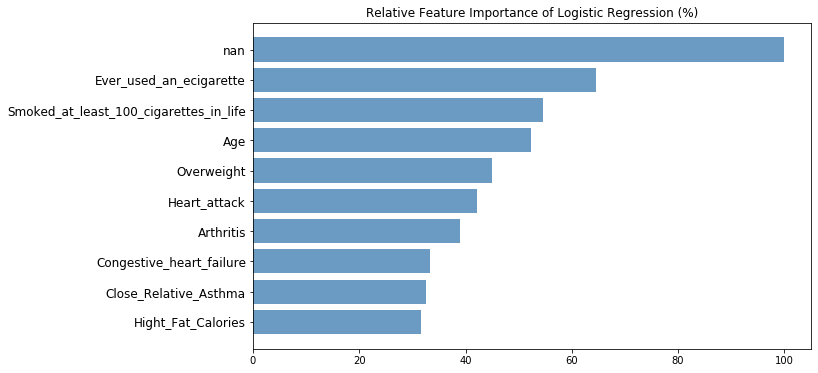

In [99]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,6))

share = feature_importance_table_desc[feature_importance_table_desc.columns[1]]
plt.barh(range(10), share, align = 'center',color='steelblue', alpha = 0.8)

plt.yticks(range(10),feature_importance_table_desc[feature_importance_table_desc.columns[0]], fontsize=12)
#ax.set_xlabels('Relative Feature Importance (%)')
#xticks(np.arange(10), ['Tom', 'Dick', 'Sue',]) 
#plt.tight_layout()   
plt.title('Relative Feature Importance of Logistic Regression (%)')
plt.show()

The accuracy and F1 is no as high as expected, I tried XGBoost Tree.

Besides, speaking of feature importance, we now have two problems.

First of all, we can only get feature importance for the whole model, while each factor may have different impact on different individuals,  we cannot see the performance of individuals in each specific factor.

Secondly, feature importance could vary from models, it could even be different within a model with different calculation options. We need to find a measure can are both consistent and accurate.




**Solution:**

Try other models use “SHAP value” and show the visualization feature importance for each individual after showing the risk score.

**What is SHAP Value?**


SHAP (SHapley Additive exPlanation) is a game theoretic approach to explain the output of any machine learning model. The goal of SHAP is to explain the prediction for any instance xᵢ as a sum of contributions from it’s individual feature values. Individual feature values are assumed to be in a cooperative game whose payout is the prediction. In this setting, Shapley values provides a measure to fairly distribute the payout among the feature values.


### XGBoost Tree

In [14]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [70]:


# find the best parameter

nmc = 100 

# set up dictionary for grid search
#  dictionary name must now include pipeline function name then __

n_estimators = 100
max_depth = range(3,10,2)
gamma = [i/10.0 for i in range(0,5)]
min_child_weight = range(1,6,2)

param_grid={'gamma': gamma,'max_depth': max_depth,'min_child_weight': min_child_weight}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.2,n_splits=nmc,random_state=25)
# set up search
grid_search=GridSearchCV(XGBClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,Y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_depth','param_min_child_weight','param_gamma']])


    rank_test_score  mean_test_score param_max_depth param_min_child_weight  \
0                 5         0.927620               3                      1   
1                 8         0.927593               3                      3   
2                14         0.927537               3                      5   
3                27         0.915870               5                      1   
4                23         0.918815               5                      3   
5                19         0.921444               5                      5   
6                53         0.895917               7                      1   
7                44         0.907315               7                      3   
8                34         0.914148               7                      5   
9                60         0.882083               9                      1   
10               50         0.898444               9                      3   
11               40         0.909083               9

In [15]:
# use best parameters: max_depth= 3, min_child_weight= 5, gamma=0.3
xgb = XGBClassifier(
 max_depth= 3, 
 min_child_weight= 5,
 gamma=0.3,
 learning_rate =0.1,
 n_estimators=1000,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)


xgb.fit(X_train,Y_train)
print('Training score:', xgb.score(X_train,Y_train))
print('Testing score:',xgb.score(X_test,Y_test))


Training score: 0.9423280423280423
Testing score: 0.8993827160493827


no severe overfitting problems

In [69]:
# confusion matrix
        
pred = xgb.predict(X_test)
confusion_matrix(y_true=Y_test, y_pred=pred)

array([[1456,   49],
       [ 114,    1]])

In [70]:
print(classification_report(y_true=Y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1505
           1       0.02      0.01      0.01       115

    accuracy                           0.90      1620
   macro avg       0.47      0.49      0.48      1620
weighted avg       0.86      0.90      0.88      1620



# Risk Score

In [79]:
risk_score = 100*xgb.predict_proba(X).reshape(-1,1)



In [80]:

reshaped_X_test = pd.DataFrame(X)
reshaped_X_test.index = np.arange(0,len(X))
reshaped_risk_score = pd.DataFrame(risk_score)

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ["Gender","NonHispanic_White","NonHispanic_Black", "Mexican_American", "Other_Hispanic", "NonHispanic_Asian","Edu","Widowed_Divorced_Separated","Married","Diabetes","Worried_anxious_daily","Worried_anxious_weekly","Worried_anxious_monthly","Worried_anxious_A_few_times_a_year","Worried_anxious_never","Depressed_daily","Depresseds_weekly","Depressed_monthly","Depressed_A_few_times_a_year","Depressed_never","serious_difficulty_walking","Asthma","Arthritis","Coronary_heart_disease","Congestive_heart_failure","Heart_attack","Stroke","Close_Relative_Heart_Attack","Close_Relative_Asthma","Close_Relative_Diabetes","Overweight","Lack_Exercise","High_Salt","Hight_Fat_Calories","More_emergency_room_visits_or_overnight_hospital_stays","Exposure_to_secondhand_smoke","Smoked_at_least_100_cigarettes_in_life","Ever_smoked_a_cigar_even_one_time","Ever_used_an_ecigarette","Ever_used_smokeless_tobacco","Age","Risk_Score"]                    
risk_score.head()                

,Gender,NonHispanic_White,NonHispanic_Black,Mexican_American,Other_Hispanic,NonHispanic_Asian,Edu,Widowed_Divorced_Separated,Married,Diabetes,...,High_Salt,Hight_Fat_Calories,More_emergency_room_visits_or_overnight_hospital_stays,Exposure_to_secondhand_smoke,Smoked_at_least_100_cigarettes_in_life,Ever_smoked_a_cigar_even_one_time,Ever_used_an_ecigarette,Ever_used_smokeless_tobacco,Age,Risk_Score
0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.700000,66.353050
1,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.550000,33.646950
2,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.966667,98.002609
3,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.966667,1.997394
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866667,60.620750


## Feature Importance

In [16]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [17]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

## Visualize a single prediction

In [18]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

The above is the risk score visualization for an individual whose risk score is 98 (the third person in the test dataset), his age (96), lack of excercise, smoking history contributed to his high risk of geting COPD.

In [217]:
shap.force_plot(explainer.expected_value, shap_values[:1636,:], X.iloc[:1636,:])

## SHAP Summary Plot
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

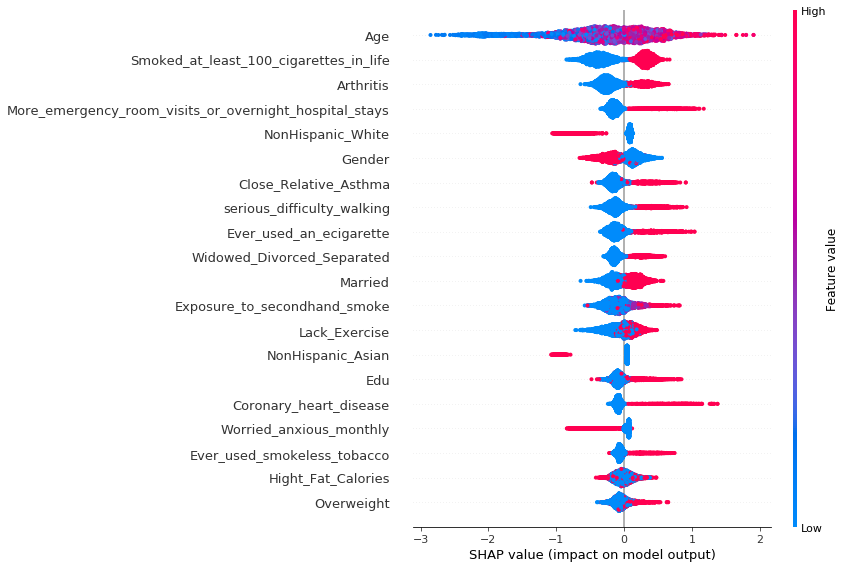

In [19]:


shap.summary_plot(shap_values, X)

From the chart above, we can not only see the rank of importance predictors, we can also see their contributions (directions) to the risk score. Take age as an example, the redder the nods the older the individual is, the red nods clustered on the right side of SHAP value = 0, which means the older the individual is the higher he/she get COPD.

## Bar chart of mean importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

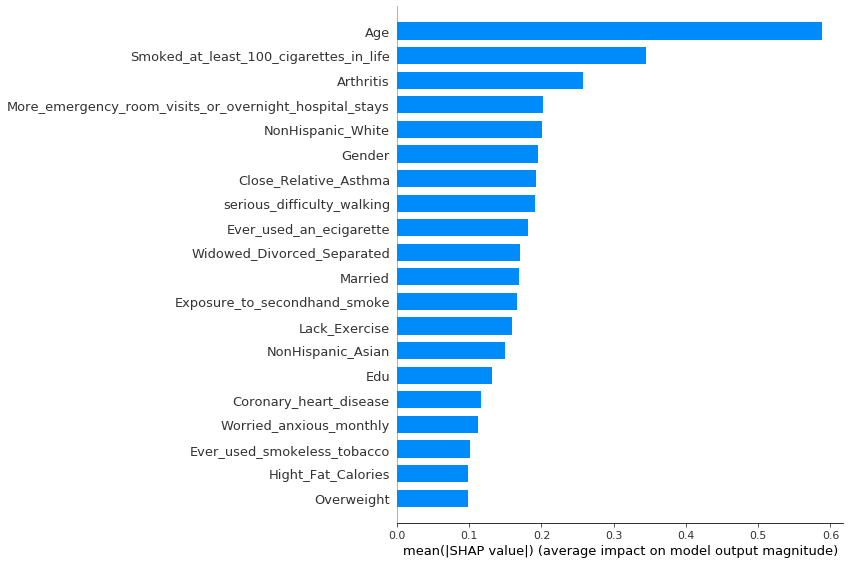

In [20]:
shap.summary_plot(shap_values, X, plot_type="bar")

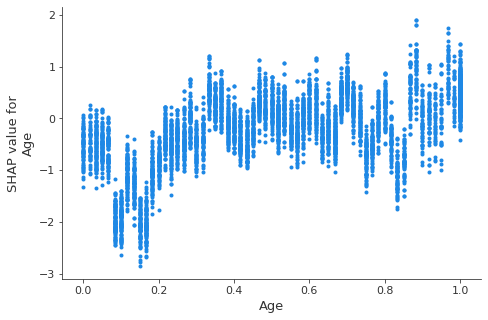

In [62]:
shap.dependence_plot('Age', shap_values, X, interaction_index=None, show=False)

## Adding Physical Conditions

Physical Conditions such as Experience_confusion_or_memory_problems, Walking_up_ten_steps_difficulty, Limitations_keeping_you_from_working, Going_out_to_movies_events_difficulty, Attending_social_event_difficulty, Leisure_activity_at_home_difficulty can also be risk factors, however, the more conditions, the smaller screened dataset is. We have 1620 rows before with 115 patients, after adding physical condition predictors we only have 124 rows with 12 patients.

There is a trade-off, and I want to figure out which method is better in this case.

In [31]:
data = pd.read_csv('COPD(normalized_all).csv')

In [32]:
data=data.iloc[:,2:]
data = data.drop(['RaceOther Race - Including Multi-Racial'], axis=1)
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 60 columns):
Gender                                                    412 non-null int64
Mexican_American                                          412 non-null int64
Other_Hispanic                                            412 non-null int64
NonHispanic_White                                         412 non-null int64
NonHispanic_Black                                         412 non-null int64
NonHispanic_Asian                                         412 non-null int64
Edu                                                       412 non-null int64
Widowed_Divorced_Separated                                412 non-null int64
Married                                                   412 non-null int64
Diabetes                                                  412 non-null int64
Worried_anxious_daily                                     412 non-null int64
Worried_anxious_weekly                          

In [33]:
Y=data['y']
X=data.ix[:,:-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
trainDf = pd.concat([Y_train, X_train], axis=1)
testDf = pd.concat([Y_test, X_test], axis=1)
clasTest = testDf.groupby('y')['y'].count()
print(clasTest)

y
0    112
1     12
Name: y, dtype: int64


## Modeling Process

### XGBoost Tree

In [ ]:


# find the best parameter

nmc = 100 

# set up dictionary for grid search
#  dictionary name must now include pipeline function name then __

n_estimators = 100
max_depth = range(3,10,2)
gamma = [i/10.0 for i in range(0,5)]
min_child_weight = range(1,6,2)

param_grid={'gamma': gamma,'max_depth': max_depth,'min_child_weight': min_child_weight}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.2,n_splits=nmc,random_state=25)
# set up search
grid_search=GridSearchCV(XGBClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,Y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_depth','param_min_child_weight','param_gamma']])


In [25]:
# use best parameters: max_depth= 7, min_child_weight= 5, gamma=0.2
xgb = XGBClassifier(
 max_depth= 7, 
 min_child_weight= 5,
 gamma=0.2,
 learning_rate =0.1,
 n_estimators=1000,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)


xgb.fit(X_train,Y_train)
print('Training score:', xgb.score(X_train,Y_train))
print('Testing score:',xgb.score(X_test,Y_test))


Training score: 0.9305555555555556
Testing score: 0.8709677419354839


In [26]:
# confusion matrix
        
pred = xgb.predict(X_test)
confusion_matrix(y_true=Y_test, y_pred=pred)

array([[108,   4],
       [ 12,   0]])

In [27]:
print(classification_report(y_true=Y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       112
           1       0.00      0.00      0.00        12

    accuracy                           0.87       124
   macro avg       0.45      0.48      0.47       124
weighted avg       0.81      0.87      0.84       124



Compared with the XGBtree with no phycial condition predictors, the model with all predictors has lower accuracy and F1 score.

## Risk Score

In [35]:
risk_score = 100*xgb.predict_proba(X).reshape(-1,1)



In [36]:

reshaped_X_test = pd.DataFrame(X)
reshaped_X_test.index = np.arange(0,len(X))
reshaped_risk_score = pd.DataFrame(risk_score)

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ["Gender","Mexican_American","Other_Hispanic","NonHispanic_White","NonHispanic_Black",  "NonHispanic_Asian","Edu","Widowed_Divorced_Separated","Married","Diabetes","Worried_anxious_daily","Worried_anxious_weekly","Worried_anxious_monthly","Worried_anxious_A_few_times_a_year","Worried_anxious_never","Depressed_daily","Depresseds_weekly","Depressed_monthly","Depressed_A_few_times_a_year","Depressed_never","serious_difficulty_walking","Asthma","Arthritis","Coronary_heart_disease","Congestive_heart_failure","Heart_attack","Stroke","Close_Relative_Heart_Attack","Close_Relative_Asthma","Close_Relative_Diabetes","Overweight","Lack_Exercise","High_Salt","Hight_Fat_Calories","More_emergency_room_visits_or_overnight_hospital_stays","Exposure_to_secondhand_smoke","Smoked_at_least_100_cigarettes_in_life","Ever_smoked_a_cigar_even_one_time","Ever_used_an_ecigarette","Ever_used_smokeless_tobacco","Experience_confusion_or_memory_problems","Walking_up_ten_steps_difficulty_No","Walking_up_ten_steps_difficulty_Some","Walking_up_ten_steps_difficulty_Much","Walking_up_ten_steps_difficulty_Unable","Limitations_keeping_you_from_working","Going_out_to_movies_events_difficulty_No","Going_out_to_movies_events_difficulty_Some","Going_out_to_movies_events_difficulty_Much","Going_out_to_movies_events_difficulty_Unable","Attending_social_event_difficulty_No","Attending_social_event_difficulty_Some","Attending_social_event_difficulty_Much","Attending_social_event_difficulty_Unable","Leisure_activity_at_home_difficulty_NO","Leisure_activity_at_home_difficulty_Some","Leisure_activity_at_home_difficulty_Much","Leisure_activity_at_home_difficulty_Unable","Age","Risk_Score"]
risk_score.head()                

,Gender,Mexican_American,Other_Hispanic,NonHispanic_White,NonHispanic_Black,NonHispanic_Asian,Edu,Widowed_Divorced_Separated,Married,Diabetes,...,Attending_social_event_difficulty_No,Attending_social_event_difficulty_Some,Attending_social_event_difficulty_Much,Attending_social_event_difficulty_Unable,Leisure_activity_at_home_difficulty_NO,Leisure_activity_at_home_difficulty_Some,Leisure_activity_at_home_difficulty_Much,Leisure_activity_at_home_difficulty_Unable,Age,Risk_Score
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.866667,99.570030
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.600000,0.429967
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.600000,93.352058
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.600000,6.647939
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,93.352058


## Feature Importance

In [37]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

## SHAP Summary Plot

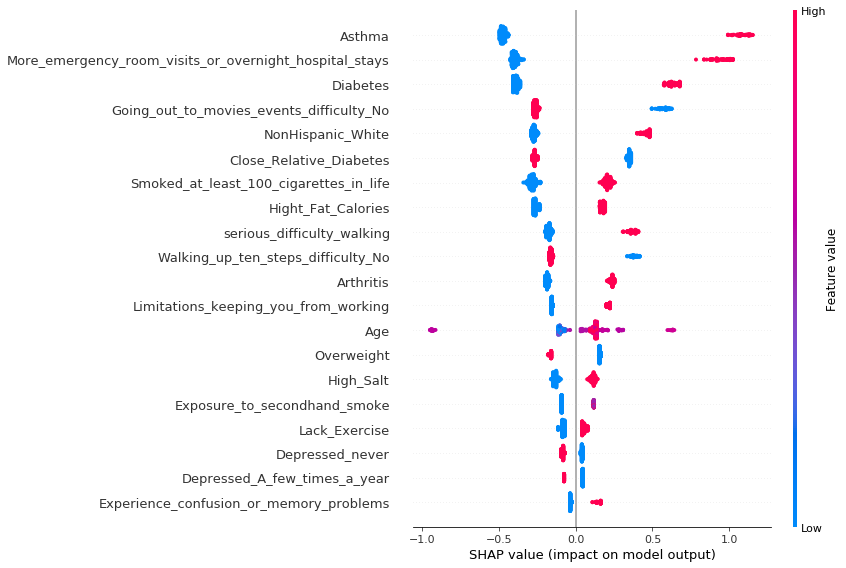

In [38]:
shap.summary_plot(shap_values, X)

## Bar chart of mean importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

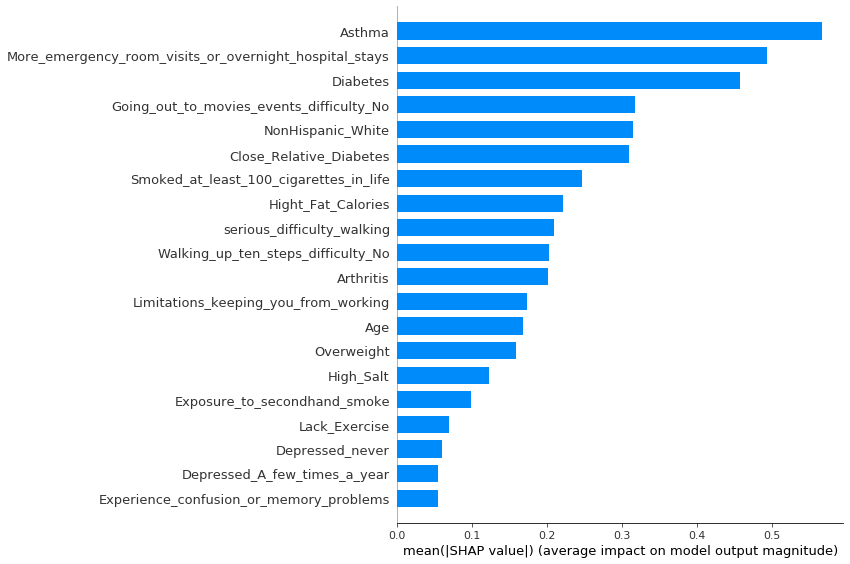

In [40]:
shap.summary_plot(shap_values, X, plot_type="bar")

We can see that the rank of the important predictors changed a lot compared with model without physical conditions. Due to the dataset is too small, I'd better use the former model with higher accuracy and more reasonable interpretation of predictors.